# Machine Learning Model Analysis and Report

The following report aims to explain and analyze the performance of a machine learning model implementation; for this particular case, a Neural Network model was developed through the SciKit Learn libraries. The NN is intended for solving multilabel classification tasks.

For the whole training and testing process of the Neural Network, a Palmer Archipielago Penguin database was used; this database contains information that allows to solve a classification problem, which consists in determining the species of a penguin based on certain features.

First, for getting the optimal model, a Gridsearch was perfrormed, aiming to get the best parameters for the neural network construction. Once the model was determined, validations were done in order to approve the model for predictions.

Once training and testing was done, several metrics were obtained in order to check if the model worked correctly when making predictions for each of the three possible outputs.

Later on, details will be given on the implementation and each particula task that was performed.

### Database Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In order to perform a successful classification task, the database must be transformed so that all variables are numeric and can be interpreted by the neural network. This encoding is also executed on the target variable, which ends up having 3 possible values.

In [2]:
df=pd.read_csv("penguins_size.csv")
df=df.dropna()
df=df[df['sex'] != "."]

X=df.drop("species",axis=1)
y=pd.DataFrame(df["species"])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(X.island.unique().tolist())
X['island']=le.transform(X['island'])

le.fit(X.sex.unique().tolist())
X['sex']=le.transform(X['sex'])

le.fit(y.species.unique().tolist())
y=le.transform(y)
y=pd.DataFrame(y,columns=['species'])

Later on, for studying if the model tends to either overfit or underfit, the database must be separated into three different subsets, training, validation and testing. The  first one will be used for generating the neural network model, so that the model gets its main parameters. Afterwards, the validation model is used for studying if the model is actually performing well with data that was not part of training, and it can be used for comparing models and if they generalize appropriately. Finally, the testing subset is used as a brand-new sample, and allows to verify if the model can perform with new information and data.

The size of the three tests was chosen accordingly to the theory studied in class, where it was specified that in most cases, using 60% of the database for training, 20% for validation and the rest for trainig, works appropriately.

In [3]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=1)

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1-train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=test_ratio/(test_ratio+validation_ratio)) 

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(199, 6)
(199, 1)
(67, 6)
(67, 1)
(67, 6)
(67, 1)


A gridsearch takes place, in order to determine which parameters work the best for the neural network model. The main objective of this search is to optimize the accuracy of predictions with the model. For the model generation, just the training subset is considered.

In [4]:
grid={"hidden_layer_sizes":[(6,2,2),(6,4,2),(6,2),(6,4),(6,1)],
    "activation":["relu","logistic"],
    "solver":["sgd","adam"],
    "learning_rate":["adaptive"],
    "learning_rate_init":[0.01,.05,0.1,0.5,1],
    "max_iter":[300],
    "random_state":[5]
}
model_gs=GridSearchCV(estimator=MLPClassifier(),param_grid=grid,refit=True,verbose=0,return_train_score=True)
model_gs.fit(X_train,y_train)

print("Best parameters: ",model_gs.best_params_)

Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (6, 4, 2), 'learning_rate': 'adaptive', 'learning_rate_init': 0.05, 'max_iter': 300, 'random_state': 5, 'solver': 'adam'}


Once the best model is determined, it can be used for checking the accuracy metric with the validation subset. As it is observed, the generated model actually performs a bit better in validation rather than in training.

In [5]:
best_model=MLPClassifier(hidden_layer_sizes=(6,4,2),activation='relu',solver='adam',learning_rate='adaptive',learning_rate_init=0.05,max_iter=300,random_state=5,verbose=False)

best_model.fit(X_train,y_train)
print("Training score: ",model_gs.score(X_train,y_train))
print("Validation score: ",model_gs.score(X_val,y_val))

Training score:  0.6482412060301508
Validation score:  0.8059701492537313


Even though the scores for both training and validation aren't optimal, they actually work fine for a simple model. It can be determined that there is no overfitting in the model, since the score for training is not high enough or perfect; at the same time, there isn't a low accuracy score for the validation set, which means that the model can actually generalize pretty well and on a similar level to the one the training has. 

On the other hand, determining underfitting can be trickier, since the score values for both training and testing aren't really high, but they are quite far away from the optimal ones. Since the accuracy values are in the range of .6 and.7, the model can be considered a bit underfitted, because there is a relatively high error while modelling and also the neural network does not perform as well as it should when generalizing for new information.

In order to evaluate how the model generalizes for new information and to understand deeply if there is underfitting or overfitting, a learning curves analysis is performed. The main objective of this graph is to detect if there is a significant change in the error that the model presents, if it is trained with a different amount of samples. Learning curves allow to understand how the accuracy or some other metric evolves within bot the training and validation set.

While studying the penguin species database, it was decided to implement a learning curve that evaluated the whole database, since the SciKit Learn library employs cross-validation for separating the database and for studying its behavior with different sample sizes.

The resulting grah shows that, at the beginning, the accuracy of the model is quite perfect if the sample size is small; once it reaches a considerable size, overfitting stops and a more realistic model is generated. At the same time, the exact opposite happens with the validation set; at first, with a small sample size the accuracy score is quite low, and while the sample gets bigger, the score tends to go higher. When the training sample size is close to 220 instances, both lines tend to converge close one to the other. This behavior shows that there is no overfitting within the model, but it has certain tendency to underfit the data, as the accuracy score is still low.

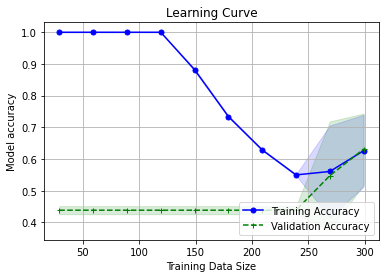

In [6]:
# Use learning curve to get training and validation scores along with train sizes

train_sizes, train_scores, val_scores = learning_curve(estimator=best_model,X=X,y=y,cv=10,train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate training and validation mean and std

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Once the training has finished and we determined the training size was adequate, a confusion matrix can be computed in order to evaluate how well the model performs when making predictions. For doing so, first some predictions had to be done while evaluating the data from the validation set with the neural network. Since the possible output consists of three different labels, the confusion matrix is formed by three rows and three columns.

In the resulting matrix, the predictions actually show that the model performs quite well when determining the Adelie and Gentoo species; however, it must be noted that when working with the validation set, the neural network never gave an output of the Chinstrap species, which could be explained by the possible underfitting of the model.

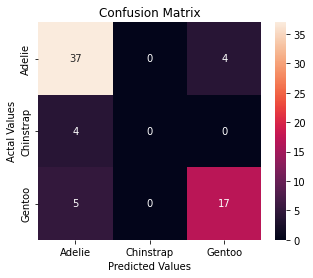

In [7]:
y_pred_val=best_model.predict(X_val)

cm_val=confusion_matrix(y_val,y_pred_val)
cm_val_df = pd.DataFrame(cm_val,index=['Adelie','Chinstrap','Gentoo'],columns=['Adelie','Chinstrap','Gentoo'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_val_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

For further study regarding the results of the confusion matrix, 4 different metrics can be computed, These metrics consider the true positives, false positives, true negatives ad false negatives for each of the possible outcomes.

Regarding each one of the metrics:

- Accuracy: metric that tries to show how well the model works when determining if an instance belongs to a class or not.
- Precision: aims to determine how the model performs when detecting a positive class.
- Recall: ratio of positive instances that were detected correctly.
- F1 score: combines precision and recall into one metric.

In [8]:
tp_a_val=cm_val[0][0]
tp_c_val=cm_val[1][1]
tp_g_val=cm_val[2][2]
fn_a_val=cm_val[0][1]+cm_val[0][2]
fn_c_val=cm_val[1][0]+cm_val[1][2]
fn_g_val=cm_val[2][0]+cm_val[2][1]
fp_a_val=cm_val[1][0]+cm_val[2][0]
fp_c_val=cm_val[0][1]+cm_val[2][1]
fp_g_val=cm_val[0][2]+cm_val[1][2]
tn_a_val=cm_val[1][1]+cm_val[1][2]+cm_val[2][1]+cm_val[2][2]
tn_c_val=cm_val[0][0]+cm_val[0][2]+cm_val[2][0]+cm_val[2][2]
tn_g_val=cm_val[0][0]+cm_val[0][1]+cm_val[1][0]+cm_val[1][1]

In [9]:
acc_a_val=(tp_a_val+tn_a_val)/(tp_a_val+tn_a_val+fp_a_val+fn_a_val)
print("Accuracy for Adelie:",acc_a_val)
pre_a_val=tp_a_val/(tp_a_val+fp_a_val)
print("Precision for Adelie:",pre_a_val)
rec_a_val=tp_a_val/(tp_a_val+fn_a_val)
print("Recall for Adelie:",rec_a_val)
f1_a_val=2*pre_a_val*rec_a_val/(pre_a_val+rec_a_val)
print("F1-score for Adelie:",f1_a_val)
acc_c_val=(tp_c_val+tn_c_val)/(tp_c_val+tn_c_val+fp_c_val+fn_c_val)
print("Accuracy for Chinstrap:",acc_c_val)
pre_c_val=tp_c_val/(tp_c_val+fp_c_val)
print("Precision for Chinstrap:",pre_c_val)
rec_c_val=tp_c_val/(tp_c_val+fn_c_val)
print("Recall for Chinstrap:",rec_c_val)
f1_c_val=2*pre_c_val*rec_c_val/(pre_c_val+rec_c_val)
print("F1-score for Chinstrap:",f1_c_val)
acc_g_val=(tp_g_val+tn_g_val)/(tp_g_val+tn_g_val+fp_g_val+fn_g_val)
print("Accuracy for Gentoo:",acc_g_val)
pre_g_val=tp_g_val/(tp_g_val+fp_g_val)
print("Precision for Gentoo:",pre_g_val)
rec_g_val=tp_g_val/(tp_g_val+fn_g_val)
print("Recall for Gentoo:",rec_g_val)
f1_g_val=2*pre_g_val*rec_g_val/(pre_g_val+rec_g_val)
print("F1-score for Gentoo:",f1_g_val)

Accuracy for Adelie: 0.8059701492537313
Precision for Adelie: 0.8043478260869565
Recall for Adelie: 0.9024390243902439
F1-score for Adelie: 0.8505747126436782
Accuracy for Chinstrap: 0.9402985074626866
Precision for Chinstrap: nan
Recall for Chinstrap: 0.0
F1-score for Chinstrap: nan
Accuracy for Gentoo: 0.8656716417910447
Precision for Gentoo: 0.8095238095238095
Recall for Gentoo: 0.7727272727272727
F1-score for Gentoo: 0.7906976744186046


Within the validation set, most of the metrics for both Adelie and Gentoo are within an acceptable range; however, Chinstrap predictions are quite weak, since there were no predictions for this class. This means that 3 out of 4 metrics are zero. The reason behind why the model behaves this way could be explained in the fact that there is some underfitting in it, as probably most of the information of the Chinstrap class is quite similar to the one of Adelie, causing that most of the predictions that actually belong to the former one go to the later one.

For further testing and analysis, the same methodology for obtaining metrics is performed with the testing subset.

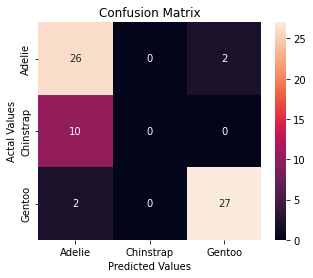

In [10]:
y_pred=best_model.predict(X_test)

cm=confusion_matrix(y_test,y_pred)
cm_df = pd.DataFrame(cm,index=['Adelie','Chinstrap','Gentoo'],columns=['Adelie','Chinstrap','Gentoo'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [11]:
tp_a=cm[0][0]
tp_c=cm[1][1]
tp_g=cm[2][2]
fn_a=cm[0][1]+cm[0][2]
fn_c=cm[1][0]+cm[1][2]
fn_g=cm[2][0]+cm[2][1]
fp_a=cm[1][0]+cm[2][0]
fp_c=cm[0][1]+cm[2][1]
fp_g=cm[0][2]+cm[1][2]
tn_a=cm[1][1]+cm[1][2]+cm[2][1]+cm[2][2]
tn_c=cm[0][0]+cm[0][2]+cm[2][0]+cm[2][2]
tn_g=cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]

In [12]:
acc_a=(tp_a+tn_a)/(tp_a+tn_a+fp_a+fn_a)
print("Accuracy for Adelie:",acc_a)
pre_a=tp_a/(tp_a+fp_a)
print("Precision for Adelie:",pre_a)
rec_a=tp_a/(tp_a+fn_a)
print("Recall for Adelie:",rec_a)
f1_a=2*pre_a*rec_a/(pre_a+rec_a)
print("F1-score for Adelie:",f1_a)
acc_c=(tp_c+tn_c)/(tp_c+tn_c+fp_c+fn_c)
print("Accuracy for Chinstrap:",acc_c)
pre_c=tp_c/(tp_c+fp_c)
print("Precision for Chinstrap:",pre_c)
rec_c=tp_c/(tp_c+fn_c)
print("Recall for Chinstrap:",rec_c)
f1_c=2*pre_c*rec_c/(pre_c+rec_c)
print("F1-score for Chinstrap:",f1_c)
acc_g=(tp_g+tn_g)/(tp_g+tn_g+fp_g+fn_g)
print("Accuracy for Gentoo:",acc_g)
pre_g=tp_g/(tp_g+fp_g)
print("Precision for Gentoo:",pre_g)
rec_g=tp_g/(tp_g+fn_g)
print("Recall for Gentoo:",rec_g)
f1_g=2*pre_g*rec_g/(pre_g+rec_g)
print("F1-score for Gentoo:",f1_g)

Accuracy for Adelie: 0.7910447761194029
Precision for Adelie: 0.6842105263157895
Recall for Adelie: 0.9285714285714286
F1-score for Adelie: 0.7878787878787878
Accuracy for Chinstrap: 0.8507462686567164
Precision for Chinstrap: nan
Recall for Chinstrap: 0.0
F1-score for Chinstrap: nan
Accuracy for Gentoo: 0.9402985074626866
Precision for Gentoo: 0.9310344827586207
Recall for Gentoo: 0.9310344827586207
F1-score for Gentoo: 0.9310344827586207


After trying out the model with the testing set, it can be confirmed that the model tends to behave in a similar way with all of the data it is presented. Metrics and the confusion matrix also confirm that predictions for both Adelie and Gentoo work fine, since there tends to be a certain generalization in the obtained results and performance. Simultaneously, when working with the Chinstrap label, the fact that there were no predictions towards it continues, which means that the model lacks enough information in order to decide that a penguin with certain characteristics belongs to this specific class.

Once the whole stody was performed and the metrics were obtained, it can be determined that even after optimizing the parameters and training/testing sizes for the neural network, there exists a certain level of underfitting, since the model fails to explain correctly when an instance belongs to the Chinstrap species. A possible solution for this would be extending the database with information from this particular class; providing more details should work for making more accurate predictions without falling into an overfitting of the model. Another option could be to generate a more complex model, which allows to adjust the predictions for that particular class; nevertheless, the gridsearch that was performed at the beginning of the analysis actually considered some neural network models which were a bit more complex, adding hidden layers and nodes to the model. This could possibly mean that a neural network is not the best option for performing a classification task with this particular database, ando some additional model could work better.